# Transferir datos de unidades  espaciales no anidadas

**IMPORTANTE:** para seguir adelante con este notebook tenemos que asegurarnos de tener instalada la librería `rtree`.

Para esta clase utilzaremos dos cartografías con unidades espaciales no superpuestas para trasnferir datos de unas a otras utilizando el porcentaje de superposición como ponderador.

Utilizaremos para ello el operador espacial `union`. Para más información sobre operadores espaciales pueden cheque la documentación de [Geopandas](http://geopandas.org/set_operations.html) o [Shapely](https://shapely.readthedocs.io/en/stable/manual.html#object.union)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mismos crs?: True


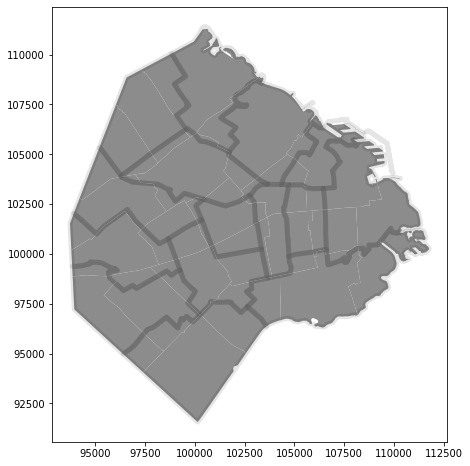

In [2]:
#leer la cartografía de comunas
com = gpd.read_file('../carto/clase_5/comunas-rar/comunas.shp')

#leer los datos de distritos escolares
dis = gpd.read_file('../carto/clase_5/distritos-escolares-rar/distritos_escolares.shp')

#chequear que tengan la misma proyeccion
print('mismos crs?:',dis.crs==com.crs)

#hacer un plot para observar la cartografia
fig,ax = plt.subplots(1,figsize=(8,8)) 
dis.plot(ax=ax,facecolor='grey',alpha=1)
com.plot(ax=ax,facecolor='white',edgecolor = 'black',alpha=0.1,linewidth=5);

## Data ejemplo

Muchas veces, para resolver un problema complejo, el mejor consejo es descomponerlo en un problema sencillo, intentar una solución y desde ahí ir incrementando el nivel de dificultad progresivamente. Siempre solucionar de un problema a la vez e ir creciendo. Para eso planteamos en este caso un ejemplo geométrico sencillo 

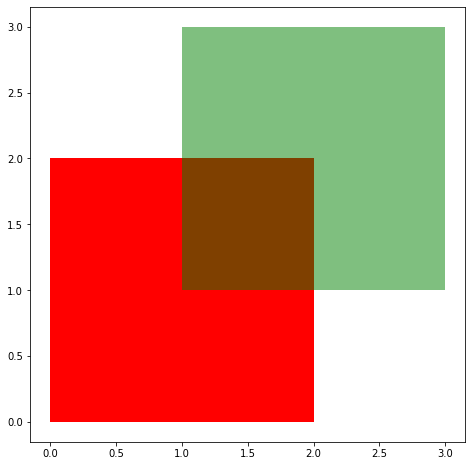

In [3]:
#importamos las funciones de shapely que nos permiten crear y manipular objetos geometricos
from shapely.geometry import Polygon, Point, LineString

polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)])])

polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)])])


A = gpd.GeoDataFrame({'geometry': polys1, 'letra':['A']})
B = gpd.GeoDataFrame({'geometry': polys2, 'letra':['B']})

f,ax = plt.subplots(1,figsize=(8,8)) 
A.plot(ax=ax, color='red')
B.plot(ax=ax, color='green', alpha=0.5);

In [4]:
A

,geometry,letra
0,"POLYGON ((0.00000 0.00000, 2.00000 0.00000, 2....",A


Unimos ambos `geoDataFrames` con el método o función `overlay`, utilizando `union` como _operador geográfico_. Qué otros operadores hay? Podemos consultar la excelente [documentación de GeoPandas](http://geopandas.org/set_operations.html).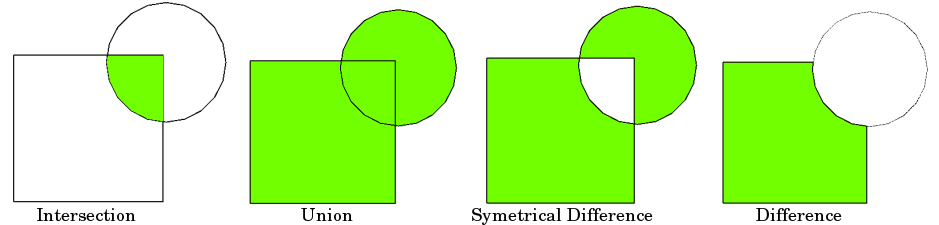

In [5]:
gpd.overlay?

In [11]:
A

,geometry,letra
0,"POLYGON ((0.00000 0.00000, 2.00000 0.00000, 2....",A


In [6]:
#realizamos el proceso de union
unido = gpd.overlay(df1 = A, df2 = B, how='union')
unido

,letra_1,letra_2,geometry
0,A,B,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
1,A,NaN,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 1...."
2,NaN,B,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 3...."


In [7]:
#Producimos una nueva columna donde agregamos los datos de cada una de los dataframes originales
unido.letra_1 = unido.letra_1.fillna('')
unido.letra_2 = unido.letra_2.fillna('')
unido['union'] = unido.letra_1 + unido.letra_2
unido

,letra_1,letra_2,geometry,union
0,A,B,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",AB
1,A,,"POLYGON ((0.00000 0.00000, 0.00000 2.00000, 1....",A
2,,B,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 3....",B


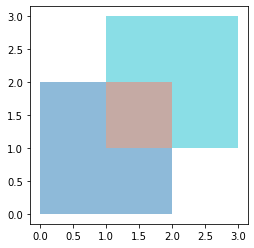

In [8]:
#hacemos un plot donde nos indique el resultado de esa union con un color diferente
unido.plot(column='union',alpha=0.5)

In [12]:
#creamos un dataframe con dos lineas
BC = pd.DataFrame({'letra_3':['C','D'],
                   'geometry':[LineString([Point(0,4),Point(4,0)]),
                               LineString([Point(1,1),Point(3,3)])
                              ]
                  }
                 )
#convertimos el DataFrame en un geoDataFrame
BC = gpd.GeoDataFrame(BC,geometry='geometry')
#pasamos de lineas a poligonos usando el buffer
BC.geometry = BC.geometry.buffer(1)
BC

,letra_3,geometry
0,C,"POLYGON ((4.70711 0.70711, 4.77301 0.63439, 4...."
1,D,"POLYGON ((2.29289 3.70711, 2.36561 3.77301, 2...."


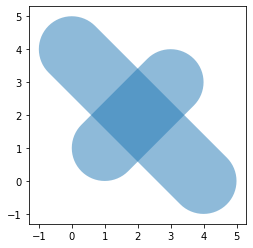

In [13]:
#ploteamos
BC.plot(alpha=0.5)

In [14]:
#realizamos una segunda union del mismo modo y repetimos el mismo proceso
unido2 = gpd.overlay(unido,BC,how='union')
for col in unido2.columns[:-1].to_list():
    unido2[col] = unido2[col].fillna('')
unido2

,letra_1,letra_2,union,letra_3,geometry
0,A,B,AB,C,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
1,A,,A,C,"MULTIPOLYGON (((1.58579 1.00000, 2.00000 1.000..."
2,,B,B,C,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 2...."
3,A,B,AB,D,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
4,A,,A,D,"POLYGON ((0.58579 2.00000, 1.00000 2.00000, 1...."
5,,B,B,D,"POLYGON ((1.00000 2.00000, 1.00000 2.41421, 1...."
6,A,,A,,"MULTIPOLYGON (((0.00000 0.00000, 0.00000 1.000..."
7,,,,C,"MULTIPOLYGON (((4.70711 0.70711, 4.77301 0.634..."
8,,,,D,"MULTIPOLYGON (((2.29289 3.70711, 2.36561 3.773..."


In [16]:
unido2['union'] = unido2.letra_1 + unido2.letra_2 + unido2.letra_3
unido2

,letra_1,letra_2,union,letra_3,geometry
0,A,B,ABC,C,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
1,A,,AC,C,"MULTIPOLYGON (((1.58579 1.00000, 2.00000 1.000..."
2,,B,BC,C,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 2...."
3,A,B,ABD,D,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2...."
4,A,,AD,D,"POLYGON ((0.58579 2.00000, 1.00000 2.00000, 1...."
5,,B,BD,D,"POLYGON ((1.00000 2.00000, 1.00000 2.41421, 1...."
6,A,,A,,"MULTIPOLYGON (((0.00000 0.00000, 0.00000 1.000..."
7,,,C,C,"MULTIPOLYGON (((4.70711 0.70711, 4.77301 0.634..."
8,,,D,D,"MULTIPOLYGON (((2.29289 3.70711, 2.36561 3.773..."


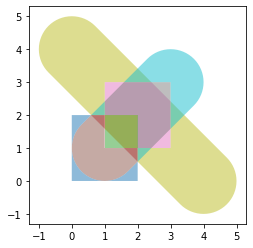

In [17]:
unido2.plot(column='union',alpha=0.5)

## Datos reales

In [18]:
#seleccionar columnas de interes, cambiarle los nombres y el formato 
com = com.reindex(columns=['COMUNAS','AREA','geometry'])
com.columns = ['COMUNA','AREA_COMUNA','geometry']
com.COMUNA = com.COMUNA.map(lambda x: str(int(x)))
com.head(2)

,COMUNA,AREA_COMUNA,geometry
0,2,6.140873e+06,"POLYGON ((107643.458 106569.299, 107641.492 10..."
1,5,6.660526e+06,"POLYGON ((104625.143 101679.935, 104629.994 10..."


In [19]:
#obtener los datos de promedio ponderado de NBI por comuna
nbi = pd.read_csv('../data/nbi_x_comuna.csv')
nbi.COMUNA = nbi.COMUNA.map(str)
nbi.head()

,COMUNA,NBI_prom
0,1,15.903845
1,4,12.658427
2,3,11.877399
3,8,11.308501
4,7,8.639839


In [20]:
#pasar los datos a la cartografía de las comunas y chequear si hay datos faltantes
com = com.merge(nbi,on = 'COMUNA',how='inner')
#realizamos un chequeo del merge
print('Comunas sin datos:',com.NBI_prom.isnull().sum())
com.head()

Comunas sin datos: 0


,COMUNA,AREA_COMUNA,geometry,NBI_prom
0,2,6.140873e+06,"POLYGON ((107643.458 106569.299, 107641.492 10...",2.035961
1,5,6.660526e+06,"POLYGON ((104625.143 101679.935, 104629.994 10...",6.053666
2,6,6.851029e+06,"POLYGON ((102998.760 102464.802, 103002.947 10...",2.202450
3,7,1.242290e+07,"POLYGON ((101036.604 99947.208, 101075.002 998...",8.639839
4,9,1.650531e+07,"POLYGON ((94869.346 99583.645, 94885.072 99583...",4.150810


In [21]:
#seleccionar y renombrar columnas de los distritos escolars
dis = dis.reindex(columns=['ROMANO','AREA','geometry'])
dis.columns = ['DISTRITO','AREA_DISTRITO','geometry']
dis.head(2)

,DISTRITO,AREA_DISTRITO,geometry
0,II,6.527968e+06,"POLYGON ((105611.166 102698.177, 105618.690 10..."
1,III,4.927409e+06,"POLYGON ((108108.830 102223.802, 108111.635 10..."


In [22]:
print('los geoDataFrame tienen el mismo sistema de coordenadas?\n Respuesta:',com.crs == dis.crs)

los geoDataFrame tienen el mismo sistema de coordenadas?
 Respuesta: True


In [23]:
#realizar la union y observar los datos
unidas = gpd.overlay(com,dis,how='union')
unidas.head()

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry
0,2,6.140873e+06,2.035961,IX,1.703833e+07,"MULTIPOLYGON (((105632.060 106199.303, 105648...."
1,14,1.577250e+07,2.354301,IX,1.703833e+07,"POLYGON ((103353.744 108568.622, 103353.843 10..."
2,15,1.432290e+07,4.284827,IX,1.703833e+07,"MULTIPOLYGON (((101698.596 104964.841, 101716...."
3,13,1.457181e+07,1.871530,IX,1.703833e+07,"MULTIPOLYGON (((103221.808 108877.851, 103229...."
4,2,6.140873e+06,2.035961,II,6.527968e+06,"MULTIPOLYGON (((105473.403 103411.531, 105465...."


### Caso ejemplo

En el cuadro de arriba podemos ver por ejemplo que el _Distrito IX_ comparte territorio con 4 Comunas: 2,14,15,13. Veamos otro caso particular como el caso 6.

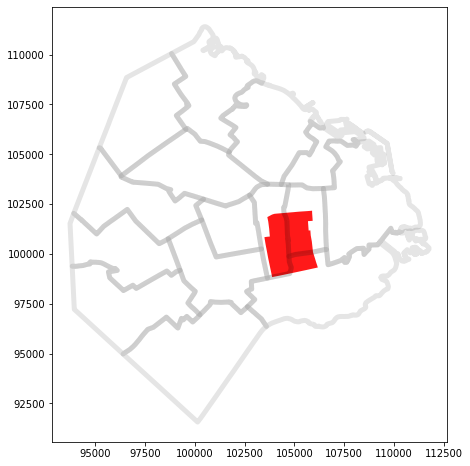

In [24]:
#tomemos un caso de ejemplo el distrito escolar 6
fig,ax = plt.subplots(1,figsize=(8,8)) 
dis.loc[dis.DISTRITO == 'VI'].plot(ax=ax,facecolor='red',alpha=1)
com.plot(ax=ax,facecolor='white',edgecolor = 'black',alpha=0.1,linewidth=5)

In [25]:
#crear un geodataframe del distrito 6
distrito6 = unidas.loc[unidas.DISTRITO == 'VI',:].copy()
distrito6

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry
27,5,6.660526e+06,6.053666,VI,6.722145e+06,"POLYGON ((104625.143 101679.935, 104629.994 10..."
28,3,6.385991e+06,11.877399,VI,6.722145e+06,"POLYGON ((105933.447 100093.981, 105933.447 10..."
29,4,2.170124e+07,12.658427,VI,6.722145e+06,"MULTIPOLYGON (((104770.200 99019.087, 104771.4..."
82,NaN,NaN,NaN,VI,6.722145e+06,"MULTIPOLYGON (((105805.645 100075.898, 105813...."


Vamos a repetir la noción de descomponer un problema complejo en problemas sencillos, encontrar una solución y luego llevar esta solución al conjunto de los casos. Observamos que se superpone con las comunas 5, 3 y 4. Vemos atributos de los dataset originales, como el area del distrito y el area de la comuna. También hay una parte del distrito que no se superpone con ninguna comuna. **Esto es algo de lo cual debemos tomar nota**

In [26]:
#calcular el area de las unidades espaciales obtenidas
distrito6['area_union'] = distrito6.geometry.area


In [27]:
#obtenemos los pesos o ponderadores como la proporción del area de las nuevas unidades espaciales 
#en realción al area de la unidad de interés, del area a donde queremos llevar los datos, es decir los distritos 
distrito6['peso'] = distrito6.area_union/distrito6.AREA_DISTRITO
distrito6.head()

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry,area_union,peso
27,5,6.660526e+06,6.053666,VI,6.722145e+06,"POLYGON ((104625.143 101679.935, 104629.994 10...",3.101228e+06,4.613451e-01
28,3,6.385991e+06,11.877399,VI,6.722145e+06,"POLYGON ((105933.447 100093.981, 105933.447 10...",2.521101e+06,3.750442e-01
29,4,2.170124e+07,12.658427,VI,6.722145e+06,"MULTIPOLYGON (((104770.200 99019.087, 104771.4...",1.099815e+06,1.636108e-01
82,NaN,NaN,NaN,VI,6.722145e+06,"MULTIPOLYGON (((105805.645 100075.898, 105813....",1.136265e-06,1.690331e-13


Vemos que la unidad espacial que no se superpone con ninguna Comuna tiene un peso despreciable. En teoría esto no debería suceder,pero puede ser que la cartografía no este perfectamente alineada y haya intersticios vacíos.

In [28]:
distrito6.loc[:,['COMUNA','NBI_prom','peso']]

,COMUNA,NBI_prom,peso
27,5,6.053666,4.613451e-01
28,3,11.877399,3.750442e-01
29,4,12.658427,1.636108e-01
82,NaN,NaN,1.690331e-13


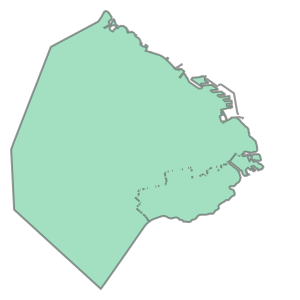

In [29]:
#creamos un campo que sea igual a todos los registros y disolvemos por ese campo, dissolviendo todas las comunas
com['diss'] = 1
com.dissolve('diss').geometry.iloc[0]

In [30]:
#chequear que los pesos den 1
distrito6.peso.sum()

1.0000000000001916

In [31]:
#Una solucoin posible es eliminar los distritos sin comunas
distrito6 = distrito6.dropna()

In [32]:
distrito6

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry,area_union,peso
27,5,6.660526e+06,6.053666,VI,6.722145e+06,"POLYGON ((104625.143 101679.935, 104629.994 10...",3.101228e+06,0.461345
28,3,6.385991e+06,11.877399,VI,6.722145e+06,"POLYGON ((105933.447 100093.981, 105933.447 10...",2.521101e+06,0.375044
29,4,2.170124e+07,12.658427,VI,6.722145e+06,"MULTIPOLYGON (((104770.200 99019.087, 104771.4...",1.099815e+06,0.163611


In [33]:
#sigue dando 1 la suma
distrito6.peso.sum()

1.0000000000000226

In [34]:
#obtener un NBI del distrito ponderando por el area que comparte dicho distrito con cada una de las comunas
sum(distrito6.NBI_prom * distrito6.peso)

9.3184330183984

In [35]:
#al ver los datos originales, se observa que el nbi debía estar en algun valor entre el del NBI de las comunas 5 y 3 
# que son las que tenían mayores pesos
com.loc[com.COMUNA.isin(['4','3','5']),['COMUNA','NBI_prom']]

,COMUNA,NBI_prom
1,5,6.053666
9,3,11.877399
12,4,12.658427


### Aplicación a todos los datos

In [36]:
#calcular el area de todas las unidades nuevas 
unidas['area_union'] = unidas.geometry.area
#calcular los pesos
unidas['peso'] = unidas.area_union / unidas.AREA_DISTRITO

unidas.head(10)

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry,area_union,peso
0,2,6.140873e+06,2.035961,IX,1.703833e+07,"MULTIPOLYGON (((105632.060 106199.303, 105648....",1.295425e+03,0.000076
1,14,1.577250e+07,2.354301,IX,1.703833e+07,"POLYGON ((103353.744 108568.622, 103353.843 10...",1.315656e+07,0.772174
2,15,1.432290e+07,4.284827,IX,1.703833e+07,"MULTIPOLYGON (((101698.596 104964.841, 101716....",1.370149e+06,0.080416
3,13,1.457181e+07,1.871530,IX,1.703833e+07,"MULTIPOLYGON (((103221.808 108877.851, 103229....",2.502960e+06,0.146902
4,2,6.140873e+06,2.035961,II,6.527968e+06,"MULTIPOLYGON (((105473.403 103411.531, 105465....",1.061262e+06,0.162572
5,5,6.660526e+06,6.053666,II,6.527968e+06,"POLYGON ((102992.994 102587.466, 102992.994 10...",2.080945e+06,0.318774
6,6,6.851029e+06,2.202450,II,6.527968e+06,"POLYGON ((102395.504 102741.138, 102396.330 10...",1.337798e+05,0.020493
7,14,1.577250e+07,2.354301,II,6.527968e+06,"POLYGON ((105051.337 104750.106, 105044.401 10...",1.389978e+06,0.212927
8,3,6.385991e+06,11.877399,II,6.527968e+06,"POLYGON ((104713.283 103467.380, 104862.315 10...",1.368343e+06,0.209612
9,15,1.432290e+07,4.284827,II,6.527968e+06,"MULTIPOLYGON (((102407.548 102748.535, 102410....",4.936592e+05,0.075622


In [37]:
#explorar los pesos de las areas que no tienen comuna: todos son muy pequeños cercanos a 0
unidas.loc[(unidas.COMUNA.isnull()),'peso'].describe()

count    1.000000e+01
mean     9.460640e-04
std      1.181128e-03
min      8.074192e-18
25%      1.724619e-05
50%      2.520499e-04
75%      1.887972e-03
max      3.054474e-03
Name: peso, dtype: float64

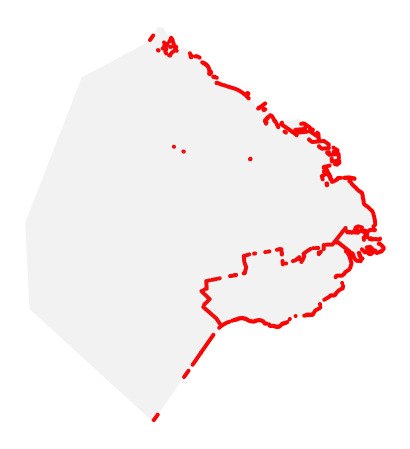

In [39]:
#vemos donde estan los null en comuna: en los márgenes
f,ax = plt.subplots(1,figsize=(8,8))
unidas.loc[(unidas.COMUNA.isnull()),:].buffer(100).plot(color = 'red',ax=ax)
com.plot(ax=ax,color='grey',alpha=0.1)
ax.set_axis_off()

In [40]:
#eliminar las zonas sin comuna ya que no inciden en el analisis
unidas = unidas.loc[unidas.COMUNA.notnull(),:]

In [41]:
#crar una función que multiplique el vector del valor de NBI por el vector del peso de ese registro y lo sume
def prom_pondera(dt):
    return sum(dt.NBI_prom * dt.peso)

In [43]:
type(unidas)

geopandas.geodataframe.GeoDataFrame

In [42]:
#aplicamos esa funcion iterando por fila
tabla = unidas.reindex(columns=['DISTRITO','NBI_prom','peso']).groupby('DISTRITO').agg(prom_pondera)
tabla = tabla.reindex(columns = ['NBI_prom'])
tabla = tabla.reset_index()
tabla.head()

,DISTRITO,NBI_prom
0,I,9.627371
1,II,5.620847
2,III,14.632114
3,IV,14.239917
4,IX,2.437583


In [44]:
unidas.head()

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry,area_union,peso
0,2,6.140873e+06,2.035961,IX,1.703833e+07,"MULTIPOLYGON (((105632.060 106199.303, 105648....",1.295425e+03,0.000076
1,14,1.577250e+07,2.354301,IX,1.703833e+07,"POLYGON ((103353.744 108568.622, 103353.843 10...",1.315656e+07,0.772174
2,15,1.432290e+07,4.284827,IX,1.703833e+07,"MULTIPOLYGON (((101698.596 104964.841, 101716....",1.370149e+06,0.080416
3,13,1.457181e+07,1.871530,IX,1.703833e+07,"MULTIPOLYGON (((103221.808 108877.851, 103229....",2.502960e+06,0.146902
4,2,6.140873e+06,2.035961,II,6.527968e+06,"MULTIPOLYGON (((105473.403 103411.531, 105465....",1.061262e+06,0.162572


In [46]:
unidas['valor_ponderado'] = unidas.NBI_prom * unidas.peso
unidas.head()

,COMUNA,AREA_COMUNA,NBI_prom,DISTRITO,AREA_DISTRITO,geometry,area_union,peso,valor_ponderado
0,2,6.140873e+06,2.035961,IX,1.703833e+07,"MULTIPOLYGON (((105632.060 106199.303, 105648....",1.295425e+03,0.000076,0.000155
1,14,1.577250e+07,2.354301,IX,1.703833e+07,"POLYGON ((103353.744 108568.622, 103353.843 10...",1.315656e+07,0.772174,1.817930
2,15,1.432290e+07,4.284827,IX,1.703833e+07,"MULTIPOLYGON (((101698.596 104964.841, 101716....",1.370149e+06,0.080416,0.344567
3,13,1.457181e+07,1.871530,IX,1.703833e+07,"MULTIPOLYGON (((103221.808 108877.851, 103229....",2.502960e+06,0.146902,0.274931
4,2,6.140873e+06,2.035961,II,6.527968e+06,"MULTIPOLYGON (((105473.403 103411.531, 105465....",1.061262e+06,0.162572,0.330990


In [48]:
unidas.reindex(columns=['DISTRITO','valor_ponderado']).groupby('DISTRITO').sum()

,valor_ponderado
DISTRITO,
I,9.627371
II,5.620847
III,14.632114
IV,14.239917
IX,2.437583
V,12.792974
VI,9.318433
VII,3.167376
VIII,5.921791


In [49]:
dis.shape

(21, 3)

In [50]:
tabla.shape

(21, 2)

In [52]:
tabla.head()

,DISTRITO,NBI_prom
0,I,9.627371
1,II,5.620847
2,III,14.632114
3,IV,14.239917
4,IX,2.437583


In [53]:
# Realizar un merge para pasar los datos a la cartografía de distritos
# cuando los nombres de la columna que une son iguales y ambas tablas tienen la misma cantidad de registros
#el merge es muy sencilo:
dis = dis.merge(tabla)

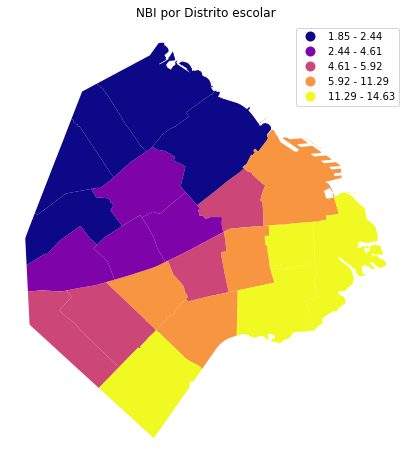

In [54]:
f,ax = plt.subplots(1,figsize=(8,8))
dis.plot(ax=ax,column='NBI_prom',legend=True,scheme='Quantiles',k=5,cmap='plasma')
ax.set_axis_off()
ax.set_title('NBI por Distrito escolar');

In [56]:
#podemos crear los campos que identifiquen la union con un nombre
unidas.COMUNA = unidas.COMUNA.fillna('')
unidas.DISTRITO = unidas.DISTRITO.fillna('')
unidas['union'] = unidas.COMUNA + ' - ' + unidas.DISTRITO
unidas.loc[:,['DISTRITO','COMUNA','union']]

,DISTRITO,COMUNA,union
0,IX,2,2 - IX
1,IX,14,14 - IX
2,IX,15,15 - IX
3,IX,13,13 - IX
4,II,2,2 - II
...,...,...,...
75,,15,15 -
76,,8,8 -
77,,4,4 -
78,,1,1 -


# Analizando poblacion que vive cerca de una estacion de subte

Vamos a realizar un caso de `overlay` tradicional mediante un _join espacial_ utilizando la función de GeoPandas `sjoin()`. El caso tradicional de uso es cuando queremos transferir información de una serie de objetos referenciados en el espacio a otros, utilizando como criterio su relación en el espacio. 

In [57]:
#cargamos nuestros shapes y proyectamos en la misma crs
carto = gpd.read_file('../carto/informacion_censal_por_radio_2010.shp')
carto = carto.to_crs(epsg=5347)

estaciones = gpd.read_file('../carto/estaciones_de_subte.shp')
estaciones = estaciones.to_crs(epsg=5347)

In [58]:
#transformamos nuestro shape de estaciones de puntos en poligonos, de 500m a la redonda,
# considerando eso como el area de influencia de la estacion  
estaciones_b = estaciones.copy()
estaciones_b.geometry = estaciones_b.buffer(500)


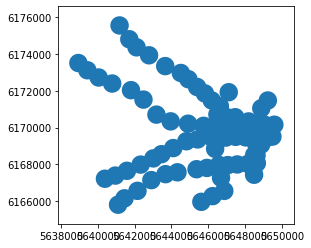

In [61]:
estaciones_b.plot()

In [63]:
gpd.sjoin?

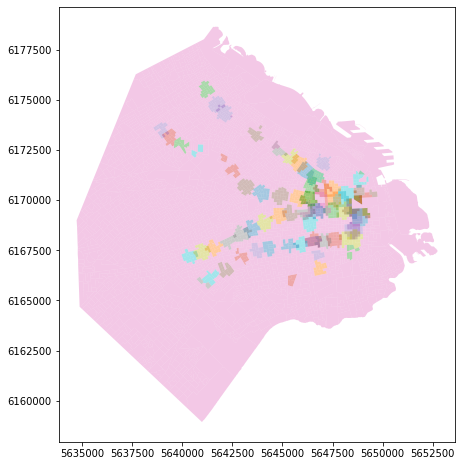

In [64]:
#realizamos un join espacial, manteniendo todos los radios y obteniendo solo la informacion de los
#radios CONTENIDOS en dicha area de influencia
left_within = gpd.sjoin(carto,estaciones_b,how='left',op='within')
left_within.ESTACION = left_within.ESTACION.fillna('Ninguna')

#ploteamos los resultados
f,ax=plt.subplots(1,figsize=(8,8))
left_within.plot(ax=ax,column='ESTACION',alpha=0.4)

In [65]:
left_within.head()

,ID_left,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,V_COLECTIV,T_HOGAR,H_CON_NBI,H_SIN_NBI,geometry,index_right,ID_right,ESTACION,LINEA
0,1,1_1_1,1,1,1,336,212,124,82.0,80,2.0,65.0,19.0,46.0,"POLYGON ((5649368.031 6171430.744, 5649356.884...",NaN,NaN,Ninguna,NaN
1,2,1_12_1,1,12,1,341,184,157,365.0,361,4.0,116.0,25.0,91.0,"POLYGON ((5648058.474 6170070.525, 5648075.017...",7.0,8.0,TRIBUNALES - TEATRO COLÓN,D
1,2,1_12_1,1,12,1,341,184,157,365.0,361,4.0,116.0,25.0,91.0,"POLYGON ((5648058.474 6170070.525, 5648075.017...",21.0,22.0,URUGUAY,B
2,3,1_12_10,1,12,10,296,162,134,629.0,627,2.0,101.0,1.0,100.0,"POLYGON ((5648711.868 6169966.266, 5648838.337...",5.0,6.0,9 DE JULIO,D
2,3,1_12_10,1,12,10,296,162,134,629.0,627,2.0,101.0,1.0,100.0,"POLYGON ((5648711.868 6169966.266, 5648838.337...",14.0,15.0,DIAGONAL NORTE,C


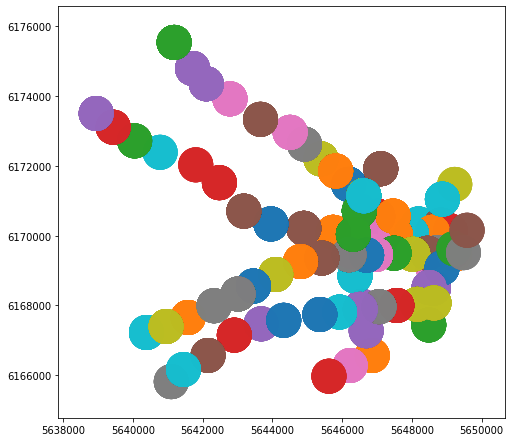

In [66]:
#realizmamos lo opuesto, manteniendo todas las estaciones y 
right_intersects = gpd.sjoin(carto,estaciones_b,how='right',op='intersects')
right_intersects.ESTACION = right_intersects.ESTACION.fillna('Ninguna')

f,ax=plt.subplots(1,figsize=(8,8))
right_intersects.plot(ax=ax,column='ESTACION',alpha=0.4)

In [68]:
# finalmente usamos la opcion por defecto, donde solo se mantienen los darios que intersectan
# con algun area de influencia estacion
radios_est = gpd.sjoin(carto,estaciones_b, how='inner',op='intersects')

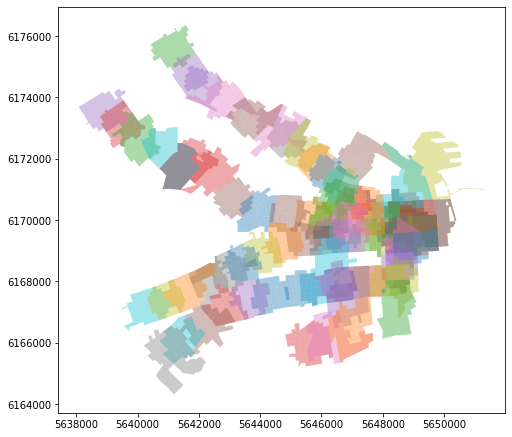

In [69]:
f,ax=plt.subplots(1,figsize=(8,8))
radios_est.plot(ax=ax,column='ESTACION',alpha=0.4)

El inconveniente con este abordaje, es que un radio puede estar dentro del área de influencia de mas de una estación. Por ejemplo los radios del nudo del Obelisco

In [70]:
#chequeamos cuantos radios estan duplicados
radios_est.CO_FRAC_RA.duplicated().sum()

1620

In [71]:
#veamos un ejemplo
radios_est.loc[radios_est.CO_FRAC_RA=='1_12_1',['CO_FRAC_RA','ESTACION','LINEA']]

,CO_FRAC_RA,ESTACION,LINEA
1,1_12_1,9 DE JULIO,D
1,1_12_1,TRIBUNALES - TEATRO COLÓN,D
1,1_12_1,C. PELLEGRINI,B
1,1_12_1,URUGUAY,B
1,1_12_1,SAENZ PEÑA,A


In [73]:
#podriamos elminar los duplicados de un modo sencillo
radios_est.drop_duplicates?

In [74]:
radios_est = radios_est.drop_duplicates(subset =['CO_FRAC_RA'],keep='first')

In [75]:
radios_est.loc[radios_est.CO_FRAC_RA=='1_12_1',:]

,ID_left,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,V_COLECTIV,T_HOGAR,H_CON_NBI,H_SIN_NBI,geometry,index_right,ID_right,ESTACION,LINEA
1,2,1_12_1,1,12,1,341,184,157,365.0,361,4.0,116.0,25.0,91.0,"POLYGON ((5648058.474 6170070.525, 5648075.017...",5,6.0,9 DE JULIO,D


In [78]:
radios_est.reindex(columns = ['CO_FRAC_RA','LINEA','ESTACION','TOTAL_POB']).head()

,CO_FRAC_RA,LINEA,ESTACION,TOTAL_POB
0,1_1_1,C,RETIRO,336
199,1_6_2,C,RETIRO,641
200,1_6_3,C,RETIRO,1160
201,1_6_4,C,RETIRO,789
202,1_6_5,C,RETIRO,332


In [79]:
#una vez eliminados los duplicados, podemos simplemente obtener la sumatoria por linea y estacion
resultados_sjoin = radios_est.reindex(columns = ['LINEA','ESTACION','TOTAL_POB']).groupby(['LINEA','ESTACION']).sum()
resultados_sjoin

TOTAL_POB
LINEA ESTACION                         
A     ACOYTE                      11521
      ALBERTI                      8084
      CARABOBO                    27398
      CASTRO BARROS               19620
      CONGRESO                    18717
...                                 ...
H     INCLAN                      13915
      LAS HERAS                   32431
      ONCE - 30 DE DICIEMBRE      15662
      PARQUE PATRICIOS             8382
      VENEZUELA                   20028

[77 rows x 1 columns]

# Un modo ligeramente mas customizado

Vamos a buscar otro modo de resolver los casos donde un mismo radio se encuentra dentro de mas de una zona de influencia. Lo haremos simplemente para el caso de la linea H. 

In [80]:
#nos quedamos con las estaciones de la linea h
lineaH = estaciones.loc[estaciones.LINEA == 'H',:]

#creamos una geometry con los poligonos representando el area de influencia mediante un buffer
lineaHbuffer = lineaH.copy()
lineaHbuffer.geometry = lineaHbuffer.geometry.buffer(500)

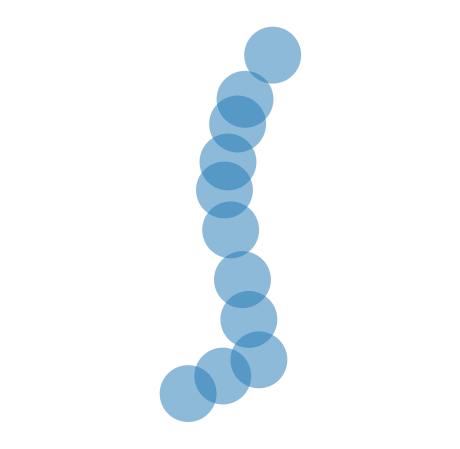

In [81]:
#mapeamos nuestras estaciones
f,ax=plt.subplots(1,figsize=(8,8))
lineaHbuffer.plot(ax=ax,alpha=0.5)
ax.set_axis_off()
plt.axis('equal');

Para procesos mas customizados, donde necesitamos tomar decisiones en base a la relacion de cada objeto geometrico en particular, utilizaremos las propiedades de los objestos `Shapely`

In [82]:
#veamos un radio particular
carto.loc[2392]

ID                                                         2393
CO_FRAC_RA                                                4_4_1
COMUNA                                                        4
FRACCION                                                      4
RADIO                                                         1
TOTAL_POB                                                   668
T_VARON                                                     315
T_MUJER                                                     353
T_VIVIENDA                                                  283
V_PARTICUL                                                  282
V_COLECTIV                                                    1
T_HOGAR                                                     236
H_CON_NBI                                                     4
H_SIN_NBI                                                   232
geometry      POLYGON ((5645193.48252013 6166219.050419812, ...
Name: 2392, dtype: object

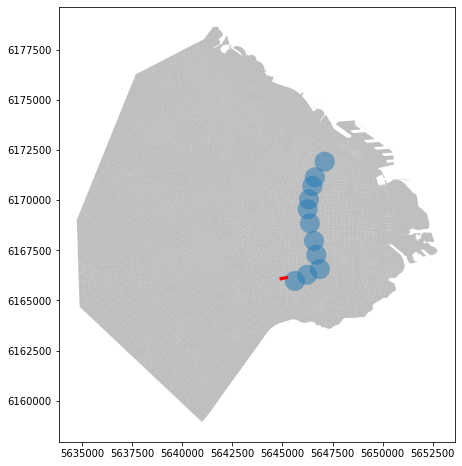

In [83]:
#ploteamos el caso
f,ax=plt.subplots(1,figsize=(8,8))
carto.plot(ax=ax,color='grey',alpha=0.5)
lineaHbuffer.plot(ax=ax,alpha=0.5)
carto.loc[[2392],:].plot(ax=ax,color='red')

Vamos a utilizar el método `intersects` del objeto `Shapely` que representa a los radios. De este modo, esto no nos devuelve con cual estaciones intersecta, sino solamente si intersecta o no con tal o cual estacion.

In [84]:
carto.geometry.loc[2392].area

70567.99753342856

In [85]:
#intersecta con VENEZUELA?
carto.geometry.loc[2392].intersects(lineaHbuffer.loc[lineaHbuffer.ESTACION=='VENEZUELA','geometry'].iloc[0])

False

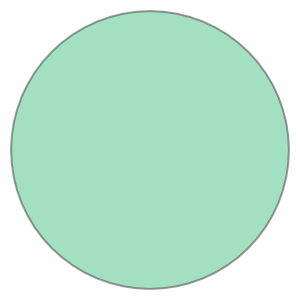

In [87]:
lineaHbuffer.loc[lineaHbuffer.ESTACION=='HOSPITALES','geometry'].iloc[0]

In [86]:
#intersecta con HOSPITALES?
carto.geometry.loc[2392].intersects(lineaHbuffer.loc[lineaHbuffer.ESTACION=='HOSPITALES','geometry'].iloc[0])

True

In [88]:
#vamos a crear una columna para cada estacion, dentro de radios, donde sea True o False de acuerdo a si intersecta
for estacion in lineaHbuffer.ESTACION:
    area_influencia = lineaHbuffer.loc[lineaHbuffer.ESTACION==estacion,'geometry'].iloc[0]
    carto[estacion] = [carto.geometry.loc[i].intersects(area_influencia) for i in carto.index]


In [89]:
carto.head()

,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,...,INCLAN,HUMBERTO 1°,VENEZUELA,ONCE - 30 DE DICIEMBRE,CORRIENTES,PARQUE PATRICIOS,HOSPITALES,CÓRDOBA,LAS HERAS,SANTA FE - CARLOS JAUREGUI
0,1,1_1_1,1,1,1,336,212,124,82.0,80,...,False,False,False,False,False,False,False,False,False,False
1,2,1_12_1,1,12,1,341,184,157,365.0,361,...,False,False,False,False,False,False,False,False,False,False
2,3,1_12_10,1,12,10,296,162,134,629.0,627,...,False,False,False,False,False,False,False,False,False,False
3,4,1_12_11,1,12,11,528,294,234,375.0,370,...,False,False,False,False,False,False,False,False,False,False
4,5,1_12_2,1,12,2,229,101,128,445.0,445,...,False,False,False,False,False,False,False,False,False,False


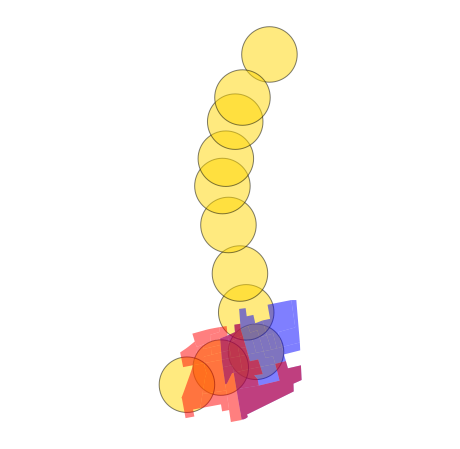

In [90]:
f,ax=plt.subplots(1,figsize=(8,8))
lineaHbuffer.plot(ax=ax,color='gold',edgecolor='black',alpha = 0.5)
carto.loc[carto['CASEROS'],:].plot(ax=ax,color='blue',alpha=0.5)
carto.loc[carto['PARQUE PATRICIOS'],:].plot(ax=ax,color='red',alpha=0.5)

ax.set_axis_off()
plt.axis('equal');

In [91]:
# sumaremos a lo largo de las filas la cantidad de veces que un registro es True, es decir 
# para cada radio, cuantas areas de influencia de estaciones intersecta 
varBuffers = lineaH.ESTACION.values
carto['q_estaciones'] = carto.loc[:,lineaH.ESTACION.values].sum(axis=1)

In [92]:
# Vemos que la mayoria de los radios no intersecta con las estaciones de la linea H. 
# Para el resto vemos que algunos intersectan con 1, 2 o hasta 3 estaciones
carto.q_estaciones.value_counts()

0    3258
1     167
2     127
3       2
Name: q_estaciones, dtype: int64

In [93]:
carto.loc[carto.q_estaciones == 3]

,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,...,HUMBERTO 1°,VENEZUELA,ONCE - 30 DE DICIEMBRE,CORRIENTES,PARQUE PATRICIOS,HOSPITALES,CÓRDOBA,LAS HERAS,SANTA FE - CARLOS JAUREGUI,q_estaciones
2415,2416,4_6_10,4,6,10,730,312,418,255.0,254,...,False,False,False,False,True,False,False,False,False,3
2424,2425,4_6_9,4,6,9,707,319,388,309.0,309,...,False,False,False,False,True,False,False,False,False,3


In [94]:
#eliminimamos los radios que no intersectan con ninguna estacion
carto = carto.loc[carto.q_estaciones>0,:]

(5644641.918723924, 5648524.787912382, 6164801.879604474, 6173280.278593447)

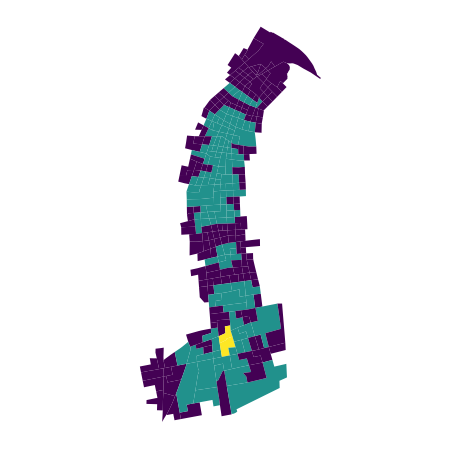

In [95]:
# Ploteamos los radios y vemos cuales son los que intersectan con mas de una estacion
f,ax=plt.subplots(1,figsize=(8,8))
carto.plot(ax=ax,column='q_estaciones')

ax.set_axis_off()
plt.axis('equal')

A partir de ahora separamos el problema en dos partes. La primera es el subconjunto de datos que no requiere mayor analisis dado que solamente tienen una estacion como area de influencia. 

In [96]:
carto1estacion = carto.loc[carto.q_estaciones==1,:]
carto1estacion

,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,...,HUMBERTO 1°,VENEZUELA,ONCE - 30 DE DICIEMBRE,CORRIENTES,PARQUE PATRICIOS,HOSPITALES,CÓRDOBA,LAS HERAS,SANTA FE - CARLOS JAUREGUI,q_estaciones
1455,1456,14_31_12,14,31,12,575,217,358,383.0,383,...,False,False,False,False,False,False,False,True,False,1
1761,1762,2_10_1,2,10,1,975,437,538,736.0,736,...,False,False,False,False,False,False,False,True,False,1
1762,1763,2_10_2,2,10,2,637,266,371,553.0,552,...,False,False,False,False,False,False,False,True,False,1
1763,1764,2_10_3,2,10,3,441,202,239,327.0,326,...,False,False,False,False,False,False,False,True,False,1
1764,1765,2_10_4,2,10,4,785,351,434,492.0,491,...,False,False,False,False,False,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,2445,4_8_6,4,8,6,710,321,389,330.0,330,...,False,False,False,False,False,False,False,False,False,1
2447,2448,4_8_9,4,8,9,1093,543,550,321.0,321,...,False,False,False,False,False,False,False,False,False,1
2575,2576,5_20_10,5,20,10,962,446,516,457.0,457,...,False,False,False,False,False,True,False,False,False,1
2576,2577,5_20_11,5,20,11,830,398,432,320.0,320,...,False,False,False,False,False,True,False,False,False,1


In [99]:
# veamos una estacion
carto1estacion.loc[1761,varBuffers]

CASEROS                       False
INCLAN                        False
HUMBERTO 1°                   False
VENEZUELA                     False
ONCE - 30 DE DICIEMBRE        False
CORRIENTES                    False
PARQUE PATRICIOS              False
HOSPITALES                    False
CÓRDOBA                       False
LAS HERAS                      True
SANTA FE - CARLOS JAUREGUI    False
Name: 1761, dtype: object

In [102]:
pd.Series({'felipe':45,'diego':45,'ana':56})

felipe    45
diego     45
ana       56
dtype: int64

In [103]:
pd.Series({'felipe':45,'diego':45,'ana':56}).idxmax()

'ana'

In [106]:
# De todas las estaciones posibles queremos quedarnos con aquella que dice True. 
# Pandas tiene un metodo para ello que nos trae el indice que alberga el valor maximo. Y True (1) es mas alto que False (0)
carto1estacion.loc[1761,varBuffers].map(int).idxmax()

'LAS HERAS'

In [107]:
#repetimos esto para todo el subcojunto 
carto1estacion['estacionFinal'] = [carto1estacion.loc[i,varBuffers].map(int).idxmax() for i in carto1estacion.index]

/home/pipe/Documents/untref/analisis_espacial_python_2019/vevn/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
carto1estacion.head()

,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,...,VENEZUELA,ONCE - 30 DE DICIEMBRE,CORRIENTES,PARQUE PATRICIOS,HOSPITALES,CÓRDOBA,LAS HERAS,SANTA FE - CARLOS JAUREGUI,q_estaciones,estacionFinal
1455,1456,14_31_12,14,31,12,575,217,358,383.0,383,...,False,False,False,False,False,False,True,False,1,LAS HERAS
1761,1762,2_10_1,2,10,1,975,437,538,736.0,736,...,False,False,False,False,False,False,True,False,1,LAS HERAS
1762,1763,2_10_2,2,10,2,637,266,371,553.0,552,...,False,False,False,False,False,False,True,False,1,LAS HERAS
1763,1764,2_10_3,2,10,3,441,202,239,327.0,326,...,False,False,False,False,False,False,True,False,1,LAS HERAS
1764,1765,2_10_4,2,10,4,785,351,434,492.0,491,...,False,False,False,False,False,False,True,False,1,LAS HERAS


In [109]:
#Finalmente obtenemos los resultados para cada estacion con los radios con una unica area de influencia 
resultado1estacion = carto1estacion.loc[:,['TOTAL_POB','estacionFinal']].groupby('estacionFinal').sum().reset_index()
resultado1estacion = resultado1estacion.rename(columns = {'TOTAL_POB':'pob_1_estacion'})
resultado1estacion

,estacionFinal,pob_1_estacion
0,CASEROS,5417
1,CORRIENTES,6589
2,CÓRDOBA,7101
3,HOSPITALES,10598
4,HUMBERTO 1°,16032
5,INCLAN,8350
6,LAS HERAS,29132
7,ONCE - 30 DE DICIEMBRE,4079
8,PARQUE PATRICIOS,3290
9,SANTA FE - CARLOS JAUREGUI,17272


A continuación, buscaremos una respuesta para aquellos radios con conflictos en el area de influencia. La solución propuesta consiste en utilizar la distancia a la estación como criterio de desempate. Es decir, que cuando un radio intersecta más de un área de influencia, se le asignará la estacion más cercana

In [110]:
#seleccionamos los casos con más de una estacion 
carto2estacion = carto.loc[carto.q_estaciones>1,:]


In [111]:
#veamos el siguiente caso donde compite entre estaciones SANTA FE - CARLOS JAUREGUI y LAS HERAS
carto2estacion.loc[1785]

ID                                                                         1786
CO_FRAC_RA                                                               2_13_4
COMUNA                                                                        2
FRACCION                                                                     13
RADIO                                                                         4
TOTAL_POB                                                                  1112
T_VARON                                                                     502
T_MUJER                                                                     610
T_VIVIENDA                                                                  742
V_PARTICUL                                                                  742
V_COLECTIV                                                                    0
T_HOGAR                                                                     555
H_CON_NBI                               

In [118]:
carto2estacion.geometry.loc[1785].centroid.distance(estaciones[estaciones.ESTACION=='LAS HERAS'].geometry.iloc[0])

586.0616141311231

In [120]:
carto2estacion.geometry.loc[1785].centroid.distance(estaciones[estaciones.ESTACION=='SANTA FE - CARLOS JAUREGUI'].geometry.iloc[0])

565.244767884787

Vemos cual de las dos es la distancia menor y nos quedaremos con esa estación. Procederemos a guardar esta informacion en una nueva columna.

In [121]:
for estacion in lineaHbuffer.ESTACION:
    estacion_influencia = estaciones[estaciones.ESTACION==estacion].geometry.iloc[0]
    carto2estacion['dist'+estacion] = [carto2estacion.geometry.loc[i].distance(estacion_influencia) for i in carto2estacion.index]
    

/home/pipe/Documents/untref/analisis_espacial_python_2019/vevn/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
carto2estacion.head()

,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,...,distINCLAN,distHUMBERTO 1°,distVENEZUELA,distONCE - 30 DE DICIEMBRE,distCORRIENTES,distPARQUE PATRICIOS,distHOSPITALES,distCÓRDOBA,distLAS HERAS,distSANTA FE - CARLOS JAUREGUI
1785,1786,2_13_4,2,13,4,1112,502,610,742.0,742,...,4334.882247,3633.596551,2764.807147,2077.356565,1581.279022,5336.847564,5711.110177,899.812401,474.910762,469.862126
1786,1787,2_13_5,2,13,5,1371,597,774,889.0,888,...,4262.479425,3563.202241,2700.452976,2019.713370,1524.612385,5271.485788,5654.411532,837.954815,430.574298,393.419966
1788,1789,2_13_7,2,13,7,1211,516,695,888.0,888,...,4195.663512,3500.457549,2649.225478,1981.498949,1490.531341,5215.994674,5612.794940,803.520570,417.809997,351.025278
1790,1791,2_14_10,2,14,10,1006,418,588,814.0,814,...,3726.689754,3025.955639,2161.659729,1484.320357,991.284207,4732.682248,5118.222182,303.295037,906.566671,0.002773
1794,1795,2_14_5,2,14,5,1124,496,628,622.0,621,...,3878.218494,3178.953969,2318.233630,1643.300668,1150.621143,4888.402005,5276.783123,462.697394,777.468754,9.520484


In [123]:
#almacenamos los nombres de las columnas que guardan la distancia de cada radio a cada estacion 
varDistance = [ u'distCASEROS',
 u'distINCLAN',
 u'distHUMBERTO 1\xb0',
 u'distVENEZUELA',
 u'distONCE - 30 DE DICIEMBRE',
 u'distCORRIENTES',
 u'distPARQUE PATRICIOS',
 u'distHOSPITALES',
 u'distC\xd3RDOBA',
 u'distLAS HERAS',
 u'distSANTA FE - CARLOS JAUREGUI']

In [124]:
#realizamos el mismo proceso que realizamos antes, 
# pero ahora utilizamos el metodo que nos tra el indice con el menor valor
carto2estacion.loc[1785,varDistance]

distCASEROS                       5052.77
distINCLAN                        4334.88
distHUMBERTO 1°                    3633.6
distVENEZUELA                     2764.81
distONCE - 30 DE DICIEMBRE        2077.36
distCORRIENTES                    1581.28
distPARQUE PATRICIOS              5336.85
distHOSPITALES                    5711.11
distCÓRDOBA                       899.812
distLAS HERAS                     474.911
distSANTA FE - CARLOS JAUREGUI    469.862
Name: 1785, dtype: object

In [125]:
#obtenemos el indice que minimice el valor de la distancia
carto2estacion.loc[1785,varDistance].map(float).idxmin() 

'distSANTA FE - CARLOS JAUREGUI'

In [126]:
#le eliminamos los primero 4 caracteres
carto2estacion.loc[1785,varDistance].map(float).idxmin()[4:]

'SANTA FE - CARLOS JAUREGUI'

In [127]:
carto2estacion['estacionFinal'] = [carto2estacion.loc[i,varDistance].map(float).idxmin()[4:] for i in carto2estacion.index]

/home/pipe/Documents/untref/analisis_espacial_python_2019/vevn/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [128]:
carto2estacion.head()

,ID,CO_FRAC_RA,COMUNA,FRACCION,RADIO,TOTAL_POB,T_VARON,T_MUJER,T_VIVIENDA,V_PARTICUL,...,distHUMBERTO 1°,distVENEZUELA,distONCE - 30 DE DICIEMBRE,distCORRIENTES,distPARQUE PATRICIOS,distHOSPITALES,distCÓRDOBA,distLAS HERAS,distSANTA FE - CARLOS JAUREGUI,estacionFinal
1785,1786,2_13_4,2,13,4,1112,502,610,742.0,742,...,3633.596551,2764.807147,2077.356565,1581.279022,5336.847564,5711.110177,899.812401,474.910762,469.862126,SANTA FE - CARLOS JAUREGUI
1786,1787,2_13_5,2,13,5,1371,597,774,889.0,888,...,3563.202241,2700.452976,2019.713370,1524.612385,5271.485788,5654.411532,837.954815,430.574298,393.419966,SANTA FE - CARLOS JAUREGUI
1788,1789,2_13_7,2,13,7,1211,516,695,888.0,888,...,3500.457549,2649.225478,1981.498949,1490.531341,5215.994674,5612.794940,803.520570,417.809997,351.025278,SANTA FE - CARLOS JAUREGUI
1790,1791,2_14_10,2,14,10,1006,418,588,814.0,814,...,3025.955639,2161.659729,1484.320357,991.284207,4732.682248,5118.222182,303.295037,906.566671,0.002773,SANTA FE - CARLOS JAUREGUI
1794,1795,2_14_5,2,14,5,1124,496,628,622.0,621,...,3178.953969,2318.233630,1643.300668,1150.621143,4888.402005,5276.783123,462.697394,777.468754,9.520484,SANTA FE - CARLOS JAUREGUI


In [129]:
resultado2estaciones = carto2estacion.loc[:,['TOTAL_POB','estacionFinal']].groupby('estacionFinal').sum().reset_index()
resultado2estaciones = resultado2estaciones.rename(columns = {'TOTAL_POB':'pob_2_estacion'})

resultado2estaciones

,estacionFinal,pob_2_estacion
0,CASEROS,4754
1,CORRIENTES,15665
2,CÓRDOBA,18439
3,HOSPITALES,4149
4,HUMBERTO 1°,6152
5,INCLAN,7120
6,LAS HERAS,713
7,ONCE - 30 DE DICIEMBRE,13792
8,PARQUE PATRICIOS,6064
9,SANTA FE - CARLOS JAUREGUI,20971


In [130]:
#realizamos un merge entre ambas tablas de resultados
resultado = resultado1estacion.merge(resultado2estaciones,on='estacionFinal')
resultado

,estacionFinal,pob_1_estacion,pob_2_estacion
0,CASEROS,5417,4754
1,CORRIENTES,6589,15665
2,CÓRDOBA,7101,18439
3,HOSPITALES,10598,4149
4,HUMBERTO 1°,16032,6152
5,INCLAN,8350,7120
6,LAS HERAS,29132,713
7,ONCE - 30 DE DICIEMBRE,4079,13792
8,PARQUE PATRICIOS,3290,6064
9,SANTA FE - CARLOS JAUREGUI,17272,20971


In [131]:
#calculamos el valor final en una nueva columna
resultado['totalPoblacion'] = resultado.pob_1_estacion + resultado.pob_2_estacion
resultado.columns = ['ESTACION','poblacion radio unico','poblacion radio compartido','poblacion total']
resultado

,ESTACION,poblacion radio unico,poblacion radio compartido,poblacion total
0,CASEROS,5417,4754,10171
1,CORRIENTES,6589,15665,22254
2,CÓRDOBA,7101,18439,25540
3,HOSPITALES,10598,4149,14747
4,HUMBERTO 1°,16032,6152,22184
5,INCLAN,8350,7120,15470
6,LAS HERAS,29132,713,29845
7,ONCE - 30 DE DICIEMBRE,4079,13792,17871
8,PARQUE PATRICIOS,3290,6064,9354
9,SANTA FE - CARLOS JAUREGUI,17272,20971,38243


Esto no preserva una cartografia unica de radios con el valor de la estacion mas cercana. Para eso podemos concatenar o appendear dos geoDataFrames, los que tenian una estacion unica y los que tenian 2.

In [132]:
#para ello utilizamos el metodo de Pandas .append() similar al de las listas.
cartoH = carto1estacion.append(carto2estacion)
cartoH.head()

/home/pipe/Documents/untref/analisis_espacial_python_2019/vevn/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,CASEROS,COMUNA,CORRIENTES,CO_FRAC_RA,CÓRDOBA,FRACCION,HOSPITALES,HUMBERTO 1°,H_CON_NBI,H_SIN_NBI,...,distHUMBERTO 1°,distINCLAN,distLAS HERAS,distONCE - 30 DE DICIEMBRE,distPARQUE PATRICIOS,distSANTA FE - CARLOS JAUREGUI,distVENEZUELA,estacionFinal,geometry,q_estaciones
1455,False,14,False,14_31_12,False,31,False,False,1.0,259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAS HERAS,"POLYGON ((5646863.508 6172348.025, 5646806.560...",1
1761,False,2,False,2_10_1,False,10,False,False,5.0,514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAS HERAS,"POLYGON ((5646677.807 6172037.304, 5646755.862...",1
1762,False,2,False,2_10_2,False,10,False,False,2.0,364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAS HERAS,"POLYGON ((5646677.807 6172037.304, 5646745.848...",1
1763,False,2,False,2_10_3,False,10,False,False,1.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAS HERAS,"POLYGON ((5646861.818 6172194.519, 5646918.936...",1
1764,False,2,False,2_10_4,False,10,False,False,1.0,343.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAS HERAS,"POLYGON ((5646935.493 6172111.547, 5646950.822...",1


In [133]:
#agregamos los datos a la cartografia de las estaciones
lineaH = lineaH.merge(resultado.loc[:,['ESTACION','poblacion total']],on='ESTACION')

In [134]:
lineaH['poblacion total'] = lineaH['poblacion total'].map(float)

In [135]:
lineaH

,ID,ESTACION,LINEA,geometry,poblacion total
0,1.0,CASEROS,H,POINT (5646864.528 6166565.318),10171.0
1,2.0,INCLAN,H,POINT (5646688.500 6167275.523),15470.0
2,3.0,HUMBERTO 1°,H,POINT (5646575.454 6167974.606),22184.0
3,4.0,VENEZUELA,H,POINT (5646368.297 6168849.054),28849.0
4,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (5646259.691 6169550.675),17871.0
5,77.0,CORRIENTES,H,POINT (5646321.246 6170042.985),22254.0
6,78.0,PARQUE PATRICIOS,H,POINT (5646230.143 6166280.647),9354.0
7,79.0,HOSPITALES,H,POINT (5645620.828 6165972.552),14747.0
8,84.0,CÓRDOBA,H,POINT (5646490.435 6170710.047),25540.0
9,85.0,LAS HERAS,H,POINT (5647106.670 6171920.277),29845.0


In [136]:
#comparamos los r
resultados_sjoin.loc['H']

,TOTAL_POB
ESTACION,
CASEROS,5417
CÓRDOBA,12214
HOSPITALES,17408
HUMBERTO 1°,8977
INCLAN,13915
LAS HERAS,32431
ONCE - 30 DE DICIEMBRE,15662
PARQUE PATRICIOS,8382
VENEZUELA,20028


(5644641.918723924, 5648524.787912382, 6164801.879604474, 6173280.278593447)

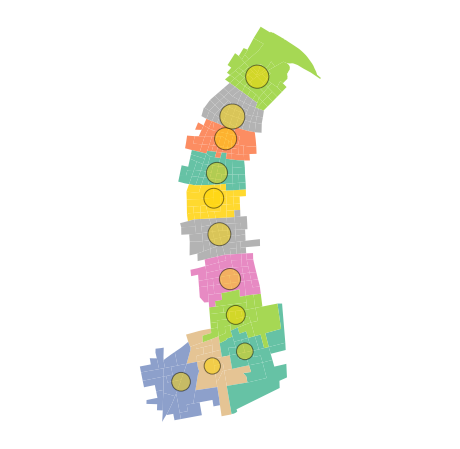

In [137]:
f,ax = plt.subplots(1,figsize=(8,8))
cartoH.plot(column = 'estacionFinal',ax=ax,cmap='Set2')
lineaH.plot(ax=ax,markersize=lineaH['poblacion total']**0.61,edgecolor='black',facecolor = 'gold',alpha=0.5)
ax.set_axis_off()
plt.axis('equal')